In [1]:
from caveclient import CAVEclient
import torch
import sys
sys.path.append('../')
from spikeometric.models import BernoulliGLM
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_dense_adj
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
sns.set_style()

# Simulating larger networks

In this example we will use synapse data from [MICrONS Explorer](https://www.microns-explorer.org/) to show that it is possible to use `spikeometric` for more than just toy examples in the 100s of neurons scale. The data is accessed using the CAVEclient API, which can be easily set up following [this guide](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/CAVEsetup.ipynb).

### Getting the data
We start by loading the proof-checked synapses from the `synapses_pni_2` dataset.

In [2]:
client = CAVEclient('minnie65_public_v117')

In [3]:
proofread=client.materialize.query_table('proofreading_status_public_release', filter_equal_dict={'status_axon':'extended'})

In [4]:
synapse_df = client.materialize.query_table('synapses_pni_2', filter_in_dict={'pre_pt_root_id': proofread.pt_root_id.values})

In [5]:
synapse_df.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,392990786,t,108313646635037887,864691136903144370,108313646635031324,864691133490688863,2168,"[316546, 181240, 16976]","[316496, 181222, 16976]","[316518, 181242, 16976]"
1,367491011,t,105919942108940243,864691134884807418,105919942108953181,864691136902999474,204,"[299484, 172656, 25069]","[299510, 172600, 25076]","[299538, 172674, 25072]"
2,203270208,t,92409555207889486,864691136011067043,92409555207885060,864691135348496087,2756,"[200798, 175720, 22249]","[200806, 175740, 22236]","[200775, 175755, 22246]"
3,402091147,t,109018021808508698,864691136309871706,109018021808492130,864691136003665354,3540,"[321836, 186342, 21141]","[321794, 186330, 21135]","[321778, 186336, 21135]"
4,142870139,t,88039065475428861,864691136209328060,88039065475431637,864691135888567689,2452,"[169414, 118904, 24336]","[169342, 118874, 24338]","[169380, 118910, 24338]"


In [6]:
print(f'Total number of synapses: {len(synapse_df)}')

Total number of synapses: 56905


We are interested in the pre- and post-synaptic neuron ids, which are stored in the `pre_pt_root_id` and `post_pt_root_id` columns.

In [7]:
synapse_df = synapse_df[['pre_pt_root_id', 'post_pt_root_id']]

Some pairs of neurons might have more than one synapse connecting them, so we count them and add them in a column to be used later. 

In [8]:
# Add column for synapse weight based on number of connections between each pair of neurons
synapse_df['W0'] = synapse_df.groupby(['pre_pt_root_id', 'post_pt_root_id'])['pre_pt_root_id'].transform('count')
synapse_df = synapse_df.drop_duplicates()
synapse_df.reset_index(drop=True, inplace=True)

We also don't want self-connections so we drop all synapses where the pre- and post-id are equal.

In [9]:
synapse_df.drop(synapse_df[synapse_df.pre_pt_root_id == synapse_df.post_pt_root_id].index, inplace=True)
synapse_df.reset_index(drop=True, inplace=True)

Now, let's reindex the synapses and look at how many synapses and neurons we are left with.

In [10]:
neurons = pd.concat([synapse_df.pre_pt_root_id, synapse_df.post_pt_root_id], ignore_index=True, axis=0).unique()
synapse_df[['pre_pt_root_id', 'post_pt_root_id']] = synapse_df[['pre_pt_root_id', 'post_pt_root_id']].apply(lambda x: x.map(dict(zip(neurons, range(len(neurons)))))) # Map indices to 0, 1, 2, ...
n_synapses = len(synapse_df)

print(f'Number of synapses: {n_synapses}')
print(f'Number of neurons: {len(neurons)}')

Number of synapses: 48654
Number of neurons: 34025


### Understanding the network
Now that we have the data, let's investigate some of the properties. We start by looking at the number of incoming vs number of incoming synapses. 

In [11]:
num_incoming = synapse_df.groupby('post_pt_root_id')['post_pt_root_id'].count()
num_outgoing = synapse_df.groupby('pre_pt_root_id')['pre_pt_root_id'].count()

print(f'Number of neurons with incoming synapses: {len(num_incoming)}')
print(f'Number of neurons with outgoing synapses: {len(num_outgoing)}')
print(f'Total number of neurons: {len(neurons)}')

Number of neurons with incoming synapses: 34000
Number of neurons with outgoing synapses: 78
Total number of neurons: 34025


We see that almost all neurons have incoming synapses, but only a few have outgoing synapses. Let's check how many have both incoming and outgoing.

In [12]:
# Number of neurons with both incoming and outgoing synapses
index_of_pre_synaptic_neurons = set(synapse_df.pre_pt_root_id)
index_of_post_synaptic_neurons = set(synapse_df.post_pt_root_id)
print(f'Number of neurons with both incoming and outgoing synapses: {len(index_of_pre_synaptic_neurons.intersection(index_of_post_synaptic_neurons))}')

Number of neurons with both incoming and outgoing synapses: 53


It is also relevant to see how many incoming and outgoing synapses each neurons has, so we plot a histogram.

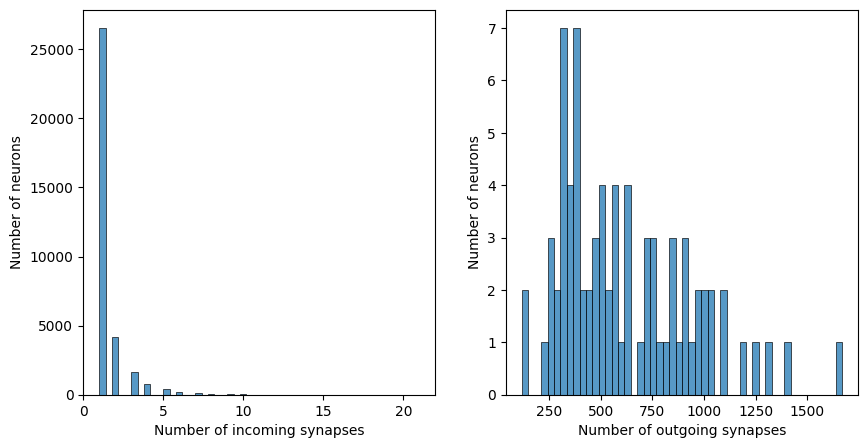

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(num_incoming, bins=50)
plt.xlabel('Number of incoming synapses')
plt.ylabel('Number of neurons')
plt.subplot(1, 2, 2)
sns.histplot(num_outgoing, bins=50)
plt.xlabel('Number of outgoing synapses')
plt.ylabel('Number of neurons')
plt.show()

We observe that among neurons with outgoing connections, there tends to be a lot of them, while most neurons have very few incoming connections.

Now we can construct a `networkx` object directly from the DateFrame, allowing us to easily compute the graph properties such as number of connected components and density.

In [14]:
G = nx.from_pandas_edgelist(synapse_df, 'pre_pt_root_id', 'post_pt_root_id', 'W0', create_using=nx.DiGraph())

In [15]:
# Compute connected components and density 
print(f'Number of connected components: {nx.number_connected_components(G.to_undirected())}')
print(f'Density: {nx.density(G)}')

Number of connected components: 1
Density: 4.202764422848513e-05


We can also plot the subgraph of a node and its neighbours

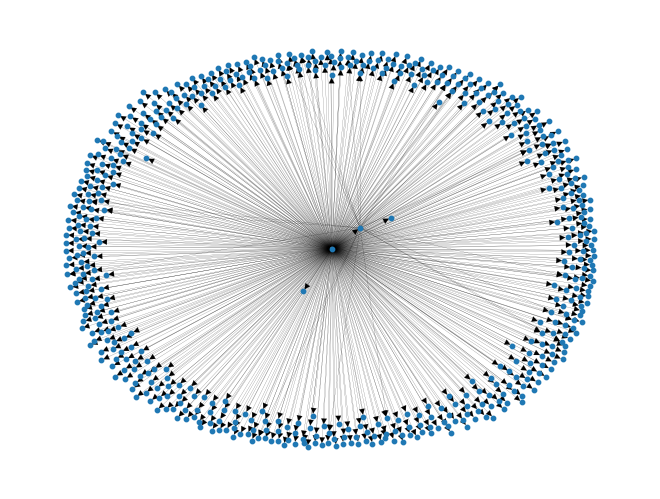

In [16]:
# Choose a random subgraph by picking a random node and including all its neighbors
subgraph = nx.ego_graph(G, radius=1, n=9, undirected=True)

# Plot the subgraph
nx.draw(subgraph, node_size=10, width=0.1)

### Simulating network activity

The network is now ready to be simulated. We will simulate the network at two different mean firing rates using the tuning functionality of `spikeometric`. 

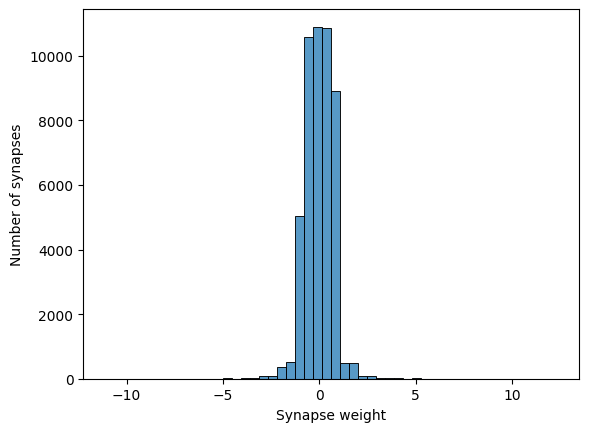

In [17]:
data = from_networkx(G) # Convert to PyTorch Geometric data object
data.W0 = data.W0.float() # Convert to float
data.W0 *= 2*(torch.rand(data.W0.shape)-0.5) # Flip sign of half of the synapses and smoothen the distribution
sns.histplot(data.W0, bins=50)
plt.xlabel('Synapse weight')
plt.ylabel('Number of synapses')
plt.show()

In [18]:
model = BernoulliGLM(
    theta=5,
    dt=1,
    coupling_window=10, 
    alpha=0.5,
    abs_ref_scale=5,
    abs_ref_strength=-100,
    rel_ref_scale=5,
    rel_ref_strength=-30,
    beta=0.1,
)

In [19]:
spikes_no_tuning = model.simulate(data, 10000, store_as_dtype=torch.uint8)

100%|██████████| 10000/10000 [00:28<00:00, 353.68it/s]


In [20]:
fr_no_tuning = spikes_no_tuning.sum(dim=1) / spikes_no_tuning.shape[1] * 1000

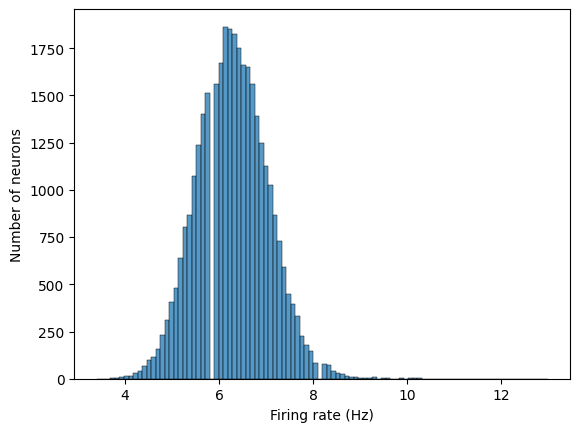

In [21]:
sns.histplot(fr_no_tuning, bins=100)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of neurons')
plt.show()

The firing rates seem to be approximately normally distributed, which is expected when interactions between neurons are relatively insignificant. We can see that interactions are limited by comparing the mean firing rate to the background firing rate and by looking at the correlation between incoming weights and firing rate.

In [22]:
# Backgroud firing rate
expected_fr = 1 / (1 + np.exp(model.theta)) * 1000
calculated_fr = fr_no_tuning.mean()
print(f'Expected firing rate: {expected_fr}')
print(f'Calculated firing rate: {calculated_fr}')
print(f'Ratio: {calculated_fr / expected_fr}')

Expected firing rate: 6.6928510665893555
Calculated firing rate: 6.298598289489746
Ratio: 0.9410934448242188


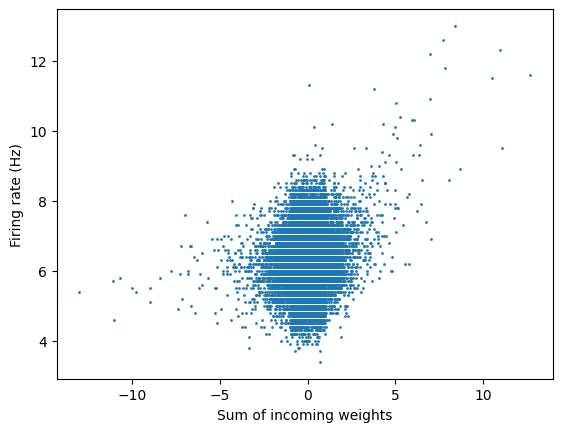

Correlation between sum of incoming weights and firing rate: 0.15216020729060095


In [23]:
# Correlate sum of incoming weights and firing rate
incoming_weights = to_dense_adj(data.edge_index, edge_attr=data.W0).sum(dim=1).squeeze()
corr = stats.pearsonr(incoming_weights, fr_no_tuning)

plt.scatter(incoming_weights, fr_no_tuning, s=1)
plt.xlabel('Sum of incoming weights')
plt.ylabel('Firing rate (Hz)')
plt.show()
print(f'Correlation between sum of incoming weights and firing rate: {corr[0]}')


We get a mean firing rate quite close to the background firing rate with no interaction and low correlation between the weights and the firing rates.

Now, let us see what happens if we tune the firing rate to 70 Hz by adjusting the background activity of the neurons (governed by the threshold $\theta$)

In [24]:
model.tune(data, firing_rate=70, tunable_parameters=['theta'], n_epochs=200)

Tuning... fr=63.78334: 100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


In [25]:
spikes = model.simulate(data, 10000, store_as_dtype=torch.uint8)

100%|██████████| 10000/10000 [00:27<00:00, 364.81it/s]


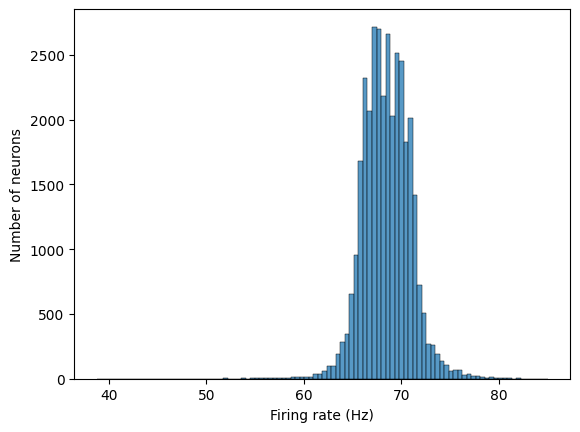

In [26]:
fr = spikes.sum(1) / spikes.shape[1] * 1000
sns.histplot(fr, bins=100)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of neurons')
plt.show()

This time the firing rates are distributed quite differently, indicating a higher degree of interactions. Let's check the same metrics that we used before tuning.

In [27]:
expected_fr = 1 / (1 + np.exp(model.theta)) * 1000
calculated_fr = fr.mean()
print(f'Expected firing rate: {expected_fr}')
print(f'Calculated firing rate: {calculated_fr}')
print(f'Ratio: {calculated_fr / expected_fr}')

Expected firing rate: 215.5343780517578
Calculated firing rate: 68.4959487915039
Ratio: 0.31779593229293823


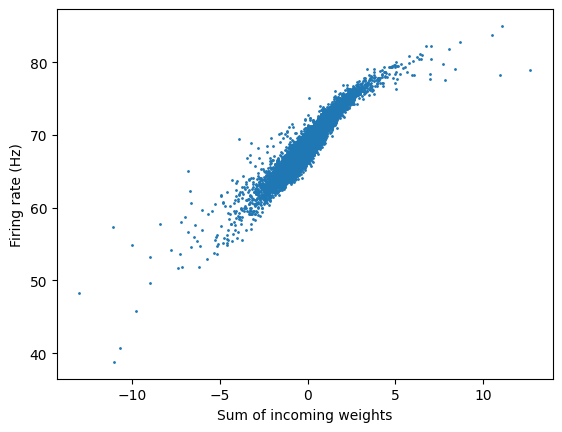

Correlation between sum of incoming weights and firing rate: 0.9300237340235159


In [28]:
# Correlate sum of incoming weights and firing rate
corr = stats.pearsonr(incoming_weights, fr)

plt.scatter(incoming_weights, fr, s=1)
plt.xlabel('Sum of incoming weights')
plt.ylabel('Firing rate (Hz)')
plt.show()
print(f'Correlation between sum of incoming weights and firing rate: {corr[0]}')

This time around, the expected firing rate and the calculated firing rate differ greatly and the firing rates correlate heavily with the incoming weights.

### Conclusion
We have seen how we can use `spikeometric` to run experiments on a publicly available synapse dataset with a large number of neurons and synapses. We saw how `Pandas`, `networkx`, `torch_geometric` can work nicely with `spikeometric` to facilitate exploration of the dataset, and uncovered an interesting difference in the behaviour of the network in low- and high-activity regimes.